# Sheet 2: Maximum Likelihood Estimation

In this exercise sheet, we will look at various properties of maximum-likelihood estimation, and how to find maximum-likelihood parameters.

### ML vs. James Stein Estimator (15 P)

Let $X_1,\dots,X_n \in \mathbb{R}^d$ be independent draws from a multivariate Gaussian distribution with mean vector $\mu$ and covariance matrix $\Sigma = \sigma^2 I$. It can be shown that the maximum-likelihood estimator of the mean parameter $\mu$ is the empirical mean given by:
$$
\hat \mu_\text{ML} = \frac1N \sum_{i=1}^N X_i
$$
It was once believed that the maximum-likelihood estimator was the most accurate possible (i.e. the one with the smallest Euclidean distance from the true mean). However, it was later demonstrated that the following estimator
$$
\hat \mu_{JS} = \Big(1-\frac{(d-2) \cdot \sigma^2}{n \cdot \|\mu_\text{ML}\|^2}\Big) \hat \mu_\text{ML}
$$
(a shrinked version of the maximum-likelihood estimator towards the origin) has actually a smaller distance from the true mean when $d \geq 3$. This however assumes knowledge of the variance of the distribution for which the mean is estimated. This estimator is called the James-Stein estimator. While the proof is a bit involved, this fact can be easily demonstrated empirically through simulation. This is the object of this exercise.

The code below draws ten 50-dimensional points from a normal distribution with mean vector $\mu = (1,\dots,1)$ and covariance $\Sigma = I$.

In [1]:
def getdata(seed):

    n = 10              # data points
    d = 50              # dimensionality of data
    m = np.ones([d])    # true mean
    s = 1.0             # true standard deviation

    rstate = np.random.mtrand.RandomState(seed)
    X = rstate.normal(0,1,[n,d])*s+m
    
    return X,m,s

The following function computes the maximum likelihood estimator from a sample of the data assumed to be generated by a Gaussian distribution:

In [2]:
def ML(X):
    return X.mean(axis=0)

* **Based on the ML estimator function, write a function that receives as input the data $(X_i)_{i=1}^n$ and the (known) variance $\sigma^2$ of the generating distribution, and computes the James-Stein estimator**

In [3]:
def JS(X,v):
    n, d = X.shape
    m_ML = X.mean(axis=0)
    m_JS = (1-(((d - 2)*v)/(n*np.dot(m_ML.T, m_ML))))*m_ML
    return m_JS

We would like to compute the error of the maximum likelihood estimator and the James-Stein estimator for 100 different samples (where each sample consists of 10 draws generated by the function `getdata` with a different random seed). Here, for reproducibility, we use seeds from 0 to 99. The error should be measured as the Euclidean distance between the true mean vector and the estimated mean vector.

* **Compute the maximum-likelihood and James-Stein estimations.**
* **Measure the error of these estimations.**
* **Build a scatter plot comparing these errors for different samples.**

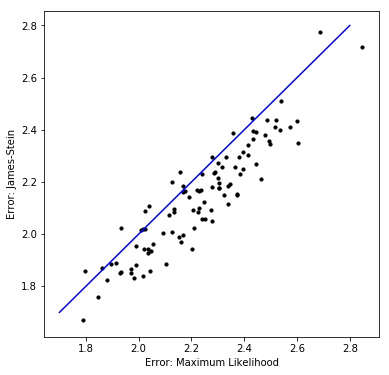

In [4]:
import numpy as np
import matplotlib 
%matplotlib inline 
from matplotlib import pyplot as plt

error_ML = []
error_JS = []
for i in range(100):
    X, m, s = getdata(i)
    d_ML = m - ML(X)
    d_JS = m - JS(X, s**2)
    euclid_d_ML = np.sqrt(np.dot(d_ML.T, d_ML))
    euclid_d_JS = np.sqrt(np.dot(d_JS.T, d_JS))
    error_ML.append(euclid_d_ML)
    error_JS.append(euclid_d_JS)
    
plt.figure(figsize=(6,6))
plt.plot(np.arange(1.7,2.9,0.1),np.arange(1.7,2.9,0.1), c='b')
plt.scatter(error_ML, error_JS, color='black', s=10) 
plt.xlabel("Error: Maximum Likelihood") 
plt.ylabel("Error: James-Stein")

### Parameters of a mixture of exponentials (15 P)

We consider the following "mixture of exponentials" distribution supported on $\mathbb{R}^+$, that we use to generate data, but whose parameters $\alpha$ and $\beta$ are unknown.

$$p(x;\alpha,\beta) = 0.5 \cdot \big[\alpha e^{-\alpha x} + \beta e^{-\beta x}\big]$$

A dataset $\mathcal{D} = x_1,\dots,x_N$ with $N=200$ has been generated from that distribution. It is given below and plotted as a histogram.

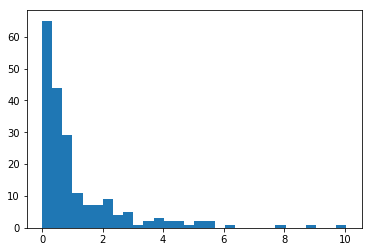

In [5]:
D=[ 0.74,  0.20,  0.56,  0.05,  0.67,  0.41,  0.74,  4.63,  0.59,  0.39,
    0.71,  0.17,  5.34,  0.33,  0.01,  1.11,  0.60,  0.41,  0.65,  1.97,
    0.19,  0.80,  0.04,  0.48,  0.54,  0.59,  0.31,  1.40,  0.63,  0.38,
    0.36,  0.02,  0.68,  0.72,  0.84,  0.30,  0.01,  1.37,  0.89,  0.10,
    0.21,  0.68,  0.14,  0.10,  0.11,  0.01,  0.09,  0.50,  0.34,  0.30,
    1.22, 10.05,  0.19,  0.04,  0.13,  1.53,  2.28,  1.76,  0.03,  0.31,
    0.37,  0.50,  0.05,  0.30,  0.53,  0.63,  4.20,  0.86,  0.29,  1.98,
    1.27,  0.35,  0.43,  0.35,  0.75,  0.25,  1.15,  1.65,  0.82,  0.37,
    2.55,  2.75,  3.06,  0.97,  2.65,  8.97,  0.04,  2.98,  0.36,  0.01,
    0.85,  0.90,  0.09,  0.01,  0.82,  2.30,  2.09,  0.29,  0.16,  2.12,
    5.28,  0.27,  0.15,  1.02,  0.51,  0.02,  1.72,  1.35,  0.51,  0.27,
    1.05,  2.24,  3.93,  0.62,  3.38,  0.56,  0.49,  2.84,  0.27,  0.12,
    3.99,  0.16,  0.09,  3.61,  0.54,  0.08,  0.31,  1.38,  0.63,  0.61,
    0.21,  0.13,  2.28,  2.61,  4.60,  0.02,  0.34,  0.15,  0.07,  2.44,
    0.86,  0.73,  2.01,  0.26,  0.72,  1.56,  0.09,  0.97,  0.24,  0.92,
    1.05,  0.71,  1.28,  3.79,  1.32,  0.17,  0.39,  2.82,  0.12,  2.06,
    2.04,  0.00,  1.94,  0.27,  0.91,  0.36,  0.92,  5.69,  0.33,  0.69,
    1.00,  2.19,  0.01,  0.08,  1.16,  0.31,  0.83,  0.41,  1.27,  0.08,
    4.69,  0.65,  0.43,  0.10,  2.92,  0.06,  6.21,  0.90,  0.00,  0.52,
    0.65,  0.26,  1.94,  0.37,  0.50,  5.66,  4.24,  0.40,  0.39,  7.89]

%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(D,bins=30)
plt.show()

For this dataset, the log-likelihood function is given by

\begin{align*}
\ell(\alpha,\beta) &= \log \prod_{i=1}^N p(x_i;\alpha,\beta) = \sum_{i=1}^N \log (e^{-\alpha x_i} + \beta e^{-\beta x_i}) - \log (2)
\end{align*}

Unfortunately, it is difficult to extract the parameters $\alpha,\beta$ analytically by solving directly the equation $\nabla \ell = 0$. Instead, we will analyze the function over a grid of parameters $\alpha$, $\beta$. We know a priori that parameters $\alpha$ and $\beta$ are in the intervals $[0.4,1.0]$ and $[1.5,4.5]$ respectively.

* **Build a grid on this limited domain and evaluate log-likelihood at each point of the grid.**
* **Plot the log-likelihood function as a contour plot, and superpose the grid to it.**

Highest log-likelihood values (i.e. most probable parameters) should appear in red, and lowest values should be plotted in blue. Two adjacent lines of the contour plot should represent a log-likelihood difference of 1.0. In your code, favor numpy array operations over Python loops.

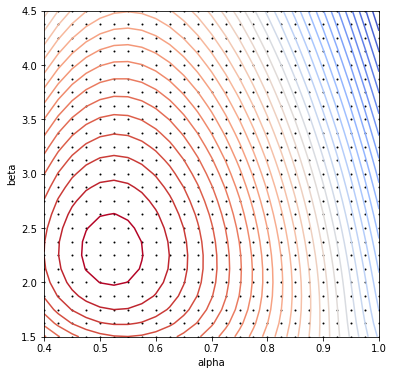

In [6]:
a_range = np.arange(0.4, 1.025, 0.1/4) 
b_range = np.arange(1.5, 4.55, 0.5/4)
a, b = np.meshgrid(a_range, b_range)

Log_L = np.zeros(a.shape)
for x in D:
    Log_L = ((np.log(a*np.exp(-a*x) + b*np.exp(-b*x))) - np.log(2)) + Log_L
    
fig = plt.figure(figsize=(6,6)) 
plt.axis([0.4, 1.0, 1.5, 4.5]) 
levels = np.arange(np.amin(Log_L),np.amax(Log_L))
plt.contour(a, b, Log_L, cmap='coolwarm', levels=levels)
plt.scatter(a, b, color='black', s=1) 
plt.xlabel("alpha"); plt.ylabel("beta")

### Gradent-Based Optimization (10 P)

As an alternative to computing the log-likelihood for a whole grid, we would like to find the optimal parameters $\alpha,\beta$ by gradient-based optimization. The partial derivatives of the log-likelihood function are given by:

\begin{align*}
\frac{\partial \ell(\alpha,\beta)}{\partial \alpha} &= \sum_{i=1}^N \frac{e^{-\alpha x_i} (1 - \alpha x_i)}{\alpha e^{-\alpha x_i} + \beta e^{-\beta x_i}}\\
\frac{\partial \ell(\alpha,\beta)}{\partial \beta} &= \sum_{i=1}^N \frac{e^{-\beta x_i} (1 - \beta x_i)}{\alpha e^{-\alpha x_i} + \beta e^{-\beta x_i}}
\end{align*}

A gradient ascent step of the log-likelihood function takes the form

$$
\begin{pmatrix}
\alpha\\
\beta
\end{pmatrix} \leftarrow
\begin{pmatrix}
\alpha\\
\beta
\end{pmatrix} + \gamma \nabla_{\alpha,\beta} \ell(\alpha,\beta)
$$

where $\gamma$ is a learning rate to be defined. We start with initial parameters $\alpha=0.7$ and $\beta=3.0$.


* **Implement the gradient ascent procedure.**
* **Run the gradient ascent with parameter $\gamma = 0.005$.**
* **Plot the trajectory of the gradient ascent in superposition to the contour plot of the previous exercise.**

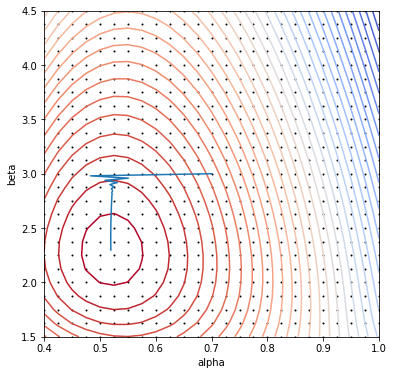

In [7]:
def gradient(a, b, D):
    d = np.asarray(D)
    dLog_L_da = np.sum(np.exp(-a*d)*(1-a*d) / (a*np.exp(-a*d)+b*np.exp(-b*d)))
    dLog_L_db = np.sum(np.exp(-b*d)*(1-b*d) / (a*np.exp(-a*d)+b*np.exp(-b*d)))
    return np.array([dLog_L_da, dLog_L_db])


def gradient_ascent(parameters, gamma, D, epochs): 
    estimates = [parameters]
    for i in range(epochs):
        parameters = parameters + gamma*gradient(parameters[0], parameters[1], D) 
        estimates.append(parameters)
    return np.array([estimates])

alpha = 0.7
beta = 3.0
gamma = 0.005
epochs = 100

parameters = np.array([alpha, beta]) 
estimates = gradient_ascent(parameters, gamma, D, epochs)

fig = plt.figure(figsize=(6,6)) 
plt.axis([0.4, 1.0, 1.5, 4.5]) 
levels = np.arange(np.amin(Log_L),np.amax(Log_L))
plt.xlabel("alpha"); plt.ylabel("beta")
plt.plot(estimates.T[0], estimates.T[1])
plt.contour(a, b, Log_L, cmap='coolwarm', levels=levels)
plt.scatter(a, b, color='black', s=1)

As it can be seen, the optimization procedure does not converge in reasonable time and seems to oscillate.

* **Explain the problem(s) with this approach. Propose a simple improvement of the optimization technique and apply it.**

##### Problems:
* Fast increase of α when compared to increase of β.
* This approach needs too many iterations to reach the maximum-likelihood.

##### Solution:
* Apply different learning rates for both parameters. Instead of γ = 0.005 we use: γα = 0.002, γβ = 0.050.

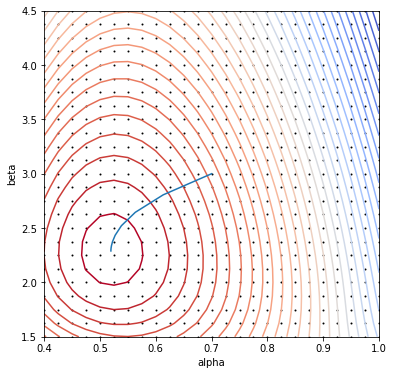

In [8]:
alpha = 0.7
beta = 3.0
gamma_a = 0.002
gamma_b = 0.050
epochs = 10

gamma = np.array([gamma_a, gamma_b])
parameters = np.array([alpha, beta]) 
estimates = gradient_ascent(parameters, gamma, D, epochs)

fig = plt.figure(figsize=(6,6)) 
plt.axis([0.4, 1.0, 1.5, 4.5]) 
levels = np.arange(np.amin(Log_L),np.amax(Log_L))
plt.xlabel("alpha"); plt.ylabel("beta")
plt.plot(estimates.T[0], estimates.T[1])
plt.contour(a, b, Log_L, cmap='coolwarm', levels=levels)
plt.scatter(a, b, color='black', s=1)